# Supervised graph classification with GCN


This notebook demonstrates how to train a graph classification model in a supervised setting using graph convolutional layers followed by a mean pooling layer as well as any number of fully connected layers.

The graph convolutional classification model architecture is based on the one proposed in [1] (see Figure 5 in [1]) using the graph convolutional layers from [2]. This demo differs from [1] in the dataset, MUTAG, used here; MUTAG is a collection of static graphs representing chemical compounds with each graph associated with a binary label. Furthermore, none of the graph convolutional layers in our model utilise an attention head as proposed in [1].

Evaluation data for graph kernel-based approaches shown in the very last cell in this notebook are taken from [3].

**References**

[1] Fake News Detection on Social Media using Geometric Deep Learning, F. Monti, F. Frasca, D. Eynard, D. Mannion, and M. M. Bronstein, ICLR 2019. ([link](https://arxiv.org/abs/1902.06673))

[2] Semi-supervised Classification with Graph Convolutional Networks, T. N. Kipf and M. Welling, ICLR 2017. ([link](https://arxiv.org/abs/1609.02907))

[3] An End-to-End Deep Learning Architecture for Graph Classification, M. Zhang, Z. Cui, M. Neumann, Y. Chen, AAAI-18. ([link](https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewPaper/17146))

In [ ]:
import stellargraph as sg
import networkx as nx

In [ ]:
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
# from stellargraph.mapper import FullBatchNodeGenerator
# mapper.FullBatchNodeGenerator(graph, method="gcn")
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph

from stellargraph import datasets

from sklearn import model_selection
from IPython.display import display, HTML

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import pprint
from stellargraph.datasets.dataset_loader import DatasetLoader

## Import the data

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [ ]:
def _load_graph_kernel_dataset(dataset):
    expected_files = dataset.expected_files
    A_filename = expected_files[0]
    graph_indicator_filename = expected_files[1]
    node_labels_filename = expected_files[2]
    edge_labels_filename = expected_files[3]
    graph_labels_filename = expected_files[4]
    
    def _load_from_txt_file(filename, names=None, dtype=None, index_increment=None):
        df = pd.read_csv(filename,header=None,index_col=False,dtype=dtype,names=names)
        # We optional increment the index by 1 because indexing, e.g. node IDs, for this dataset starts
        # at 1 whereas the Pandas DataFrame implicit index starts at 0 potentially causing confusion selecting
        # rows later on.
        if index_increment:
            df.index = df.index + index_increment
        return df

    # edge information:
    df_graph = _load_from_txt_file(filename=A_filename, names=["source", "target"])

    if dataset._edge_labels_as_weights:
        # there's some edge labels, that can be used as edge weights
        df_edge_labels = _load_from_txt_file(
            filename=edge_labels_filename, names=["weight"], dtype=int
        )
        df_graph = pd.concat([df_graph, df_edge_labels], axis=1)

    # node information:
    df_graph_ids = _load_from_txt_file(
        filename=graph_indicator_filename, names=["graph_id"], index_increment=1
    )

    df_node_labels = _load_from_txt_file(
        filename=node_labels_filename, dtype="category", index_increment=1
    )
    # One-hot encode the node labels because these are used as node features in graph classification
    # tasks.
    df_node_features = pd.get_dummies(df_node_labels)

    # graph information:
    df_graph_labels = _load_from_txt_file(
        filename=graph_labels_filename, dtype="category", names=["label"], index_increment=1
    )

    # split the data into each of the graphs, based on the nodes in each one
    def graph_for_nodes(nodes):
        # each graph is disconnected, so the source is enough to identify the graph for an edge
        edges = df_graph[df_graph["source"].isin(nodes.index)]
        return StellarGraph(nodes, edges)

    groups = df_node_features.groupby(df_graph_ids["graph_id"])
    graphs = [graph_for_nodes(nodes) for _, nodes in groups]

    return graphs, df_graph_labels["label"]

In [ ]:
class GuavData():
    name="PPMI"
#     expected_files=["Pioneer GCN Data/GCN_A.txt",
#         "Pioneer GCN Data/GCN_graph_indicator.txt",
#         "Pioneer GCN Data/GCN_node_labels.txt",
#         "Pioneer GCN Data/GCN_edge_labels.txt",
#         "Pioneer GCN Data/GCN_graph_labels.txt"]
    expected_files=["BIG_GCN_A.txt",
            "BIG_GCN_graph_indicator.txt",
            "BIG_GCN_node_labels.txt",
            "BIG_GCN_edge_labels.txt",
            "BIG_GCN_graph_labels.txt"]
#     expected_files=["MUTAG_A.txt",
#         "MUTAG_graph_indicator.txt",
#         "MUTAG_node_labels.txt",
#         "MUTAG_edge_labels.txt",
#         "MUTAG_graph_labels.txt"]
    description="Each graph represents a brain derived from an fMRI. There are 164 nodes with 141 distinct node labels.",
    _edge_labels_as_weights = False
    _node_attributes = False

    def load(self):
        """
        Load this dataset into a list of StellarGraph objects with corresponding labels, downloading it if required.

        Note: Edges in MUTAG are labelled as one of 4 values: aromatic, single, double, and triple indicated by integers
        0, 1, 2, 3 respectively. The edge labels are included in the  :class:`.StellarGraph` objects as edge weights in
        integer representation.

        Returns:
            A tuple that is a list of :class:`.StellarGraph` objects and a Pandas Series of labels one for each graph.
        """
        return _load_graph_kernel_dataset(self)

In [ ]:
dataset = GuavData()
display(dataset.description)
graphs, graph_labels = dataset.load()

('Each graph represents a brain derived from an fMRI. There are 164 nodes with 141 distinct node labels.',)

The `graphs` value is a list of many `StellarGraph` instances, each of which has a few node features:

In [ ]:
print(graphs[0].info())

StellarGraph: Undirected multigraph
 Nodes: 164, Edges: 3124

 Node types:
  default: [164]
    Features: float32 vector, length 142
    Edge types: default-default->default

 Edge types:
    default-default->default: [3124]
        Weights: all 1 (default)
        Features: none


In [ ]:
print(graphs[1].info())

StellarGraph: Undirected multigraph
 Nodes: 164, Edges: 4248

 Node types:
  default: [164]
    Features: float32 vector, length 142
    Edge types: default-default->default

 Edge types:
    default-default->default: [4248]
        Weights: all 1 (default)
        Features: none


Summary statistics of the sizes of the graphs:

In [ ]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,240.0,240.0
mean,164.0,3444.4
std,0.0,590.6
min,164.0,0.0
25%,164.0,3274.0
50%,164.0,3490.0
75%,164.0,3704.0
max,164.0,4689.0


In [ ]:
# print(dir(dataset))

In [ ]:
# print(dir(dataset.load()[0][0]))

The labels are `1` or `0`:

In [ ]:
graph_labels.value_counts().to_frame()

,label
-1,120
1,120


In [ ]:
graph_labels = pd.get_dummies(graph_labels, drop_first=True)

### Prepare graph generator

To feed data to the `tf.Keras` model that we will create later, we need a data generator. For supervised graph classification, we create an instance of `StellarGraph`'s `PaddedGraphGenerator` class. Note that `graphs` is a list of `StellarGraph` graph objects.

In [ ]:
generator = PaddedGraphGenerator(graphs)

### Create the Keras graph classification model

We are now ready to create a `tf.Keras` graph classification model using `StellarGraph`'s `GraphClassification` class together with standard `tf.Keras` layers, e.g., `Dense`. 

The input is the graph represented by its adjacency and node features matrices. The first two layers are Graph Convolutional as in [2] with each layer having 64 units and `relu` activations. The next layer is a mean pooling layer where the learned node representation are summarized to create a graph representation. The graph representation is input to two fully connected layers with 32 and 16 units respectively and `relu` activations. The last layer is the output layer with a single unit and `sigmoid` activation.

![](graph_classification_architecture.png)

In [ ]:
def create_graph_classification_model(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    # Let's create the Keras model and prepare it for training
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(optimizer=Adam(0.004), loss=binary_crossentropy, metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"),tf.keras.metrics.Precision(name="precision"),tf.keras.metrics.Recall(name="recall"),tf.keras.metrics.TrueNegatives(name="tn"),tf.keras.metrics.FalsePositives(name="fp")])

    return model

### Train the model

We can now train the model using the model's `fit` method. First, we specify some important training parameters such as the number of training epochs, number of fold for cross validation and the number of time to repeat cross validation.

In [ ]:
epochs = 500  # maximum number of training epochs
folds = 4  # the number of folds for k-fold cross validation
n_repeats = 2  # the number of repeats for repeated k-fold cross validation

In [ ]:
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)

The method `train_fold` is used to train a graph classification model for a single fold of the data.

In [ ]:
def train_fold(model, train_gen, test_gen, es, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=2, callbacks=[es],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=1)
    print('loss:')
    print(test_metrics)
    print(model.metrics_names)
#     loss = test_metrics[model.metrics_names.index("loss")]
    test_acc = test_metrics[model.metrics_names.index("acc")]
    precision = test_metrics[model.metrics_names.index("precision")]
    recall = test_metrics[model.metrics_names.index("recall")]
    true_neg = test_metrics[model.metrics_names.index("tn")]
    false_pos = test_metrics[model.metrics_names.index("fp")]
    
    return history, test_acc, precision, recall, true_neg, false_pos

In [ ]:
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_index, targets=graph_labels.iloc[train_index].values, batch_size=batch_size
    )
    test_gen = generator.flow(
        test_index, targets=graph_labels.iloc[test_index].values, batch_size=batch_size
    )

    return train_gen, test_gen

The code below puts all the above functionality together in a training loop for repeated k-fold cross-validation where the number of folds is 10, `folds=10`; that is we do 10-fold cross validation `n_repeats` times where `n_repeats=5`.

**Note**: The below code may take a long time to run depending on the value set for `n_repeats`. The larger the latter, the longer it takes since for each repeat we train and evaluate 10 graph classification models, one for each fold of the data. For progress updates, we recommend that you set `verbose=2` in the call to the `fit` method is cell 10, line 3.

In [ ]:
test_accs = []
test_precision = []
test_recall = []
test_true_neg = []
test_false_pos = []
histories = []

stratified_folds = model_selection.RepeatedStratifiedKFold(
    n_splits=folds, n_repeats=n_repeats
).split(graph_labels, graph_labels)

In [ ]:
print(enumerate(stratified_folds).__sizeof__())

48


In [ ]:
# print(graph_labels)

In [ ]:
for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {folds * n_repeats}...")
    print("train_index" + str(train_index))
    print("test_index" + str(test_index))
    train_gen, test_gen = get_generators(
        train_index, test_index, graph_labels, batch_size=10
    )

    model = create_graph_classification_model(generator)

    history, acc, precision, recall, true_neg, false_pos= train_fold(model, train_gen, test_gen, es, epochs)

    histories.append(history)
    test_accs.append(acc)
    test_precision.append(precision)
    test_recall.append(recall)
    test_true_neg.append(true_neg)
    test_false_pos.append(false_pos)

Training and evaluating on fold 1 out of 8...
train_index[  0   1   2   3   4   5   8   9  10  11  13  14  15  16  23  25  26  28
  29  31  32  33  34  35  37  38  39  40  41  43  44  45  46  47  48  49
  50  51  52  53  54  55  57  58  61  62  63  64  66  67  69  70  72  73
  74  75  76  77  78  79  81  82  83  85  86  87  88  89  91  92  93  94
  95  98  99 101 102 104 107 108 109 110 112 113 114 115 116 117 118 119
 120 121 123 125 127 128 131 132 134 136 137 138 139 140 141 142 143 145
 147 148 149 150 151 152 153 154 155 156 157 158 161 162 163 164 165 167
 168 169 170 171 172 173 174 177 178 179 180 181 182 183 184 185 187 188
 189 192 193 194 196 197 198 199 201 202 203 204 205 208 209 210 213 215
 216 217 218 219 220 221 222 223 225 227 228 229 230 231 233 234 238 239]
test_index[  6   7  12  17  18  19  20  21  22  24  27  30  36  42  56  59  60  65
  68  71  80  84  90  96  97 100 103 105 106 111 122 124 126 129 130 133
 135 144 146 159 160 166 175 176 186 190 191 195 200 206

Epoch 31/500
18/18 - 0s - loss: 0.6481 - acc: 0.5833 - precision: 0.5573 - recall: 0.8111 - tn: 32.0000 - fp: 58.0000 - val_loss: 1.1119 - val_acc: 0.5333 - val_precision: 1.0000 - val_recall: 0.0667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 32/500
18/18 - 0s - loss: 0.6621 - acc: 0.5556 - precision: 0.5362 - recall: 0.8222 - tn: 26.0000 - fp: 64.0000 - val_loss: 0.6914 - val_acc: 0.6000 - val_precision: 0.5577 - val_recall: 0.9667 - val_tn: 7.0000 - val_fp: 23.0000
Epoch 33/500
18/18 - 0s - loss: 0.6103 - acc: 0.6111 - precision: 0.5649 - recall: 0.9667 - tn: 23.0000 - fp: 67.0000 - val_loss: 0.7377 - val_acc: 0.5667 - val_precision: 0.5417 - val_recall: 0.8667 - val_tn: 8.0000 - val_fp: 22.0000
Epoch 34/500
18/18 - 0s - loss: 0.6009 - acc: 0.6000 - precision: 0.5577 - recall: 0.9667 - tn: 21.0000 - fp: 69.0000 - val_loss: 0.6354 - val_acc: 0.6000 - val_precision: 0.5600 - val_recall: 0.9333 - val_tn: 8.0000 - val_fp: 22.0000
Epoch 35/500
18/18 - 0s - loss: 0.5804 - acc: 0.6167 - p

Epoch 66/500
18/18 - 0s - loss: 0.4286 - acc: 0.7944 - precision: 0.8630 - recall: 0.7000 - tn: 80.0000 - fp: 10.0000 - val_loss: 0.5048 - val_acc: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 67/500
18/18 - 0s - loss: 0.4181 - acc: 0.8167 - precision: 0.9130 - recall: 0.7000 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.4962 - val_acc: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 68/500
18/18 - 0s - loss: 0.4466 - acc: 0.8167 - precision: 0.8132 - recall: 0.8222 - tn: 73.0000 - fp: 17.0000 - val_loss: 0.5092 - val_acc: 0.7000 - val_precision: 1.0000 - val_recall: 0.4000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 69/500
18/18 - 0s - loss: 0.4646 - acc: 0.7500 - precision: 0.8082 - recall: 0.6556 - tn: 76.0000 - fp: 14.0000 - val_loss: 0.4993 - val_acc: 0.7167 - val_precision: 1.0000 - val_recall: 0.4333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 70/500
18/18 - 0s - loss: 0.4355 - acc:

Epoch 101/500
18/18 - 0s - loss: 0.3864 - acc: 0.8278 - precision: 0.8172 - recall: 0.8444 - tn: 73.0000 - fp: 17.0000 - val_loss: 0.5125 - val_acc: 0.6667 - val_precision: 0.8571 - val_recall: 0.4000 - val_tn: 28.0000 - val_fp: 2.0000
Epoch 102/500
18/18 - 0s - loss: 0.4442 - acc: 0.7556 - precision: 0.9259 - recall: 0.5556 - tn: 86.0000 - fp: 4.0000 - val_loss: 0.5268 - val_acc: 0.6667 - val_precision: 0.8571 - val_recall: 0.4000 - val_tn: 28.0000 - val_fp: 2.0000
Epoch 103/500
18/18 - 0s - loss: 0.3602 - acc: 0.8611 - precision: 0.9452 - recall: 0.7667 - tn: 86.0000 - fp: 4.0000 - val_loss: 0.4879 - val_acc: 0.7167 - val_precision: 0.8421 - val_recall: 0.5333 - val_tn: 27.0000 - val_fp: 3.0000
Epoch 104/500
18/18 - 0s - loss: 0.3329 - acc: 0.8778 - precision: 0.9048 - recall: 0.8444 - tn: 82.0000 - fp: 8.0000 - val_loss: 0.4769 - val_acc: 0.7333 - val_precision: 0.8889 - val_recall: 0.5333 - val_tn: 28.0000 - val_fp: 2.0000
Epoch 105/500
18/18 - 0s - loss: 0.3559 - acc: 0.8389 - pre

Epoch 136/500
18/18 - 0s - loss: 0.2831 - acc: 0.8944 - precision: 0.9176 - recall: 0.8667 - tn: 83.0000 - fp: 7.0000 - val_loss: 0.5257 - val_acc: 0.7167 - val_precision: 1.0000 - val_recall: 0.4333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 137/500
18/18 - 0s - loss: 0.2371 - acc: 0.9278 - precision: 0.9639 - recall: 0.8889 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.3359 - val_acc: 0.8500 - val_precision: 0.9200 - val_recall: 0.7667 - val_tn: 28.0000 - val_fp: 2.0000
Epoch 138/500
18/18 - 0s - loss: 0.3433 - acc: 0.8944 - precision: 0.9080 - recall: 0.8778 - tn: 82.0000 - fp: 8.0000 - val_loss: 1.0701 - val_acc: 0.9333 - val_precision: 1.0000 - val_recall: 0.8667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 139/500
18/18 - 0s - loss: 0.2814 - acc: 0.9000 - precision: 0.9091 - recall: 0.8889 - tn: 82.0000 - fp: 8.0000 - val_loss: 1.0459 - val_acc: 0.7333 - val_precision: 1.0000 - val_recall: 0.4667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 140/500
18/18 - 0s - loss: 0.2440 - acc: 0

Epoch 171/500
18/18 - 0s - loss: 0.1348 - acc: 0.9722 - precision: 0.9670 - recall: 0.9778 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.2048 - val_acc: 0.9500 - val_precision: 1.0000 - val_recall: 0.9000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 172/500
18/18 - 0s - loss: 0.1794 - acc: 0.9444 - precision: 0.9444 - recall: 0.9444 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.2057 - val_acc: 0.9333 - val_precision: 1.0000 - val_recall: 0.8667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 173/500
18/18 - 0s - loss: 0.1492 - acc: 0.9667 - precision: 0.9667 - recall: 0.9667 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.1401 - val_acc: 0.9833 - val_precision: 1.0000 - val_recall: 0.9667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 174/500
18/18 - 0s - loss: 0.1379 - acc: 0.9611 - precision: 0.9663 - recall: 0.9556 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.1447 - val_acc: 0.9667 - val_precision: 1.0000 - val_recall: 0.9333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 175/500
18/18 - 0s - loss: 0.2133 - ac

Epoch 206/500
18/18 - 0s - loss: 0.0763 - acc: 0.9722 - precision: 0.9885 - recall: 0.9556 - tn: 89.0000 - fp: 1.0000 - val_loss: 0.1349 - val_acc: 0.9667 - val_precision: 0.9667 - val_recall: 0.9667 - val_tn: 29.0000 - val_fp: 1.0000
Epoch 207/500
18/18 - 0s - loss: 0.0439 - acc: 0.9833 - precision: 0.9780 - recall: 0.9889 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.1046 - val_acc: 0.9500 - val_precision: 1.0000 - val_recall: 0.9000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 208/500
18/18 - 0s - loss: 0.0503 - acc: 0.9833 - precision: 0.9780 - recall: 0.9889 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.0708 - val_acc: 0.9833 - val_precision: 0.9677 - val_recall: 1.0000 - val_tn: 29.0000 - val_fp: 1.0000
Epoch 209/500
18/18 - 0s - loss: 0.0648 - acc: 0.9833 - precision: 0.9888 - recall: 0.9778 - tn: 89.0000 - fp: 1.0000 - val_loss: 0.1103 - val_acc: 0.9833 - val_precision: 0.9677 - val_recall: 1.0000 - val_tn: 29.0000 - val_fp: 1.0000
Epoch 210/500
18/18 - 0s - loss: 0.0601 - acc: 0.9722 - 

Epoch 241/500
18/18 - 0s - loss: 0.0421 - acc: 0.9833 - precision: 1.0000 - recall: 0.9667 - tn: 90.0000 - fp: 0.0000e+00 - val_loss: 0.4400 - val_acc: 0.8667 - val_precision: 0.8056 - val_recall: 0.9667 - val_tn: 23.0000 - val_fp: 7.0000
Epoch 242/500
18/18 - 0s - loss: 0.0425 - acc: 0.9722 - precision: 0.9670 - recall: 0.9778 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.0293 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 243/500
18/18 - 0s - loss: 0.0889 - acc: 0.9722 - precision: 0.9885 - recall: 0.9556 - tn: 89.0000 - fp: 1.0000 - val_loss: 0.0691 - val_acc: 0.9833 - val_precision: 0.9677 - val_recall: 1.0000 - val_tn: 29.0000 - val_fp: 1.0000
Epoch 244/500
18/18 - 0s - loss: 0.1039 - acc: 0.9722 - precision: 0.9775 - recall: 0.9667 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.2204 - val_acc: 0.9833 - val_precision: 1.0000 - val_recall: 0.9667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 245/500
18/18 - 0s - loss: 0.0412 - acc: 0

Epoch 3/500
18/18 - 0s - loss: 0.6968 - acc: 0.2278 - precision: 0.0196 - recall: 0.0111 - tn: 40.0000 - fp: 50.0000 - val_loss: 0.6931 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 4/500
18/18 - 0s - loss: 0.6940 - acc: 0.5222 - precision: 0.5833 - recall: 0.1556 - tn: 80.0000 - fp: 10.0000 - val_loss: 0.6939 - val_acc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_fp: 30.0000
Epoch 5/500
18/18 - 0s - loss: 0.6964 - acc: 0.5000 - precision: 0.5000 - recall: 1.0000 - tn: 0.0000e+00 - fp: 90.0000 - val_loss: 0.6949 - val_acc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_fp: 30.0000
Epoch 6/500
18/18 - 0s - loss: 0.6970 - acc: 0.5000 - precision: 0.5000 - recall: 1.0000 - tn: 0.0000e+00 - fp: 90.0000 - val_loss: 0.6943 - val_acc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_fp: 30.0000
Epoch 7/500
18/18 - 0s - loss: 0.6

Epoch 38/500
18/18 - 0s - loss: 0.5633 - acc: 0.6833 - precision: 0.8837 - recall: 0.4222 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.5854 - val_acc: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 39/500
18/18 - 0s - loss: 0.5429 - acc: 0.6944 - precision: 0.9268 - recall: 0.4222 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.5817 - val_acc: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 40/500
18/18 - 0s - loss: 0.5489 - acc: 0.6944 - precision: 0.9268 - recall: 0.4222 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.5697 - val_acc: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 41/500
18/18 - 0s - loss: 0.5522 - acc: 0.6778 - precision: 0.8636 - recall: 0.4222 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.5662 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 42/500
18/18 - 0s - loss: 0.5189 - acc: 0.

Epoch 73/500
18/18 - 0s - loss: 0.4126 - acc: 0.7556 - precision: 0.7738 - recall: 0.7222 - tn: 71.0000 - fp: 19.0000 - val_loss: 0.4930 - val_acc: 0.7000 - val_precision: 1.0000 - val_recall: 0.4000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 74/500
18/18 - 0s - loss: 0.4465 - acc: 0.7333 - precision: 0.9375 - recall: 0.5000 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.5370 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 75/500
18/18 - 0s - loss: 0.4417 - acc: 0.7333 - precision: 0.9565 - recall: 0.4889 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.5230 - val_acc: 0.7000 - val_precision: 1.0000 - val_recall: 0.4000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 76/500
18/18 - 0s - loss: 0.4605 - acc: 0.7278 - precision: 0.7356 - recall: 0.7111 - tn: 67.0000 - fp: 23.0000 - val_loss: 0.5034 - val_acc: 0.7167 - val_precision: 0.6757 - val_recall: 0.8333 - val_tn: 18.0000 - val_fp: 12.0000
Epoch 77/500
18/18 - 0s - loss: 0.4636 - acc: 0.7

Epoch 108/500
18/18 - 0s - loss: 0.4032 - acc: 0.7667 - precision: 0.7069 - recall: 0.9111 - tn: 56.0000 - fp: 34.0000 - val_loss: 0.5226 - val_acc: 0.7333 - val_precision: 0.6842 - val_recall: 0.8667 - val_tn: 18.0000 - val_fp: 12.0000
Epoch 109/500
18/18 - 0s - loss: 0.3626 - acc: 0.8278 - precision: 0.7864 - recall: 0.9000 - tn: 68.0000 - fp: 22.0000 - val_loss: 0.4995 - val_acc: 0.7833 - val_precision: 0.8148 - val_recall: 0.7333 - val_tn: 25.0000 - val_fp: 5.0000
Epoch 110/500
18/18 - 0s - loss: 0.3767 - acc: 0.8222 - precision: 0.7900 - recall: 0.8778 - tn: 69.0000 - fp: 21.0000 - val_loss: 0.4686 - val_acc: 0.8000 - val_precision: 0.8214 - val_recall: 0.7667 - val_tn: 25.0000 - val_fp: 5.0000
Epoch 111/500
18/18 - 0s - loss: 0.2962 - acc: 0.8667 - precision: 0.8367 - recall: 0.9111 - tn: 74.0000 - fp: 16.0000 - val_loss: 0.4537 - val_acc: 0.7500 - val_precision: 0.8000 - val_recall: 0.6667 - val_tn: 25.0000 - val_fp: 5.0000
Epoch 112/500
18/18 - 0s - loss: 0.3130 - acc: 0.7944 -

Epoch 143/500
18/18 - 0s - loss: 0.3253 - acc: 0.8889 - precision: 0.8889 - recall: 0.8889 - tn: 80.0000 - fp: 10.0000 - val_loss: 0.4206 - val_acc: 0.7667 - val_precision: 0.8077 - val_recall: 0.7000 - val_tn: 25.0000 - val_fp: 5.0000
Epoch 144/500
18/18 - 0s - loss: 0.2869 - acc: 0.8611 - precision: 0.9114 - recall: 0.8000 - tn: 83.0000 - fp: 7.0000 - val_loss: 0.4600 - val_acc: 0.7167 - val_precision: 1.0000 - val_recall: 0.4333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 145/500
18/18 - 0s - loss: 0.2270 - acc: 0.9056 - precision: 0.9294 - recall: 0.8778 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.5121 - val_acc: 0.7167 - val_precision: 1.0000 - val_recall: 0.4333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 146/500
18/18 - 0s - loss: 0.3452 - acc: 0.8111 - precision: 0.9375 - recall: 0.6667 - tn: 86.0000 - fp: 4.0000 - val_loss: 0.4231 - val_acc: 0.8500 - val_precision: 0.8387 - val_recall: 0.8667 - val_tn: 25.0000 - val_fp: 5.0000
Epoch 147/500
18/18 - 0s - loss: 0.3883 - acc: 0.82

Epoch 19/500
18/18 - 0s - loss: 0.6932 - acc: 0.5000 - precision: 0.5000 - recall: 1.0000 - tn: 0.0000e+00 - fp: 90.0000 - val_loss: 0.6931 - val_acc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_fp: 30.0000
Epoch 20/500
18/18 - 0s - loss: 0.6926 - acc: 0.5000 - precision: 0.5000 - recall: 1.0000 - tn: 0.0000e+00 - fp: 90.0000 - val_loss: 0.6931 - val_acc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_fp: 30.0000
Epoch 21/500
18/18 - 0s - loss: 0.6918 - acc: 0.5000 - precision: 0.5000 - recall: 1.0000 - tn: 0.0000e+00 - fp: 90.0000 - val_loss: 0.6932 - val_acc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_fp: 30.0000
Epoch 22/500
18/18 - 0s - loss: 0.6928 - acc: 0.4556 - precision: 0.3571 - recall: 0.1111 - tn: 72.0000 - fp: 18.0000 - val_loss: 0.6933 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 23/500
18/18 - 0s - l

Epoch 54/500
18/18 - 0s - loss: 0.5444 - acc: 0.7056 - precision: 0.8936 - recall: 0.4667 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.5301 - val_acc: 0.7000 - val_precision: 1.0000 - val_recall: 0.4000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 55/500
18/18 - 0s - loss: 0.5633 - acc: 0.6944 - precision: 0.8723 - recall: 0.4556 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.5159 - val_acc: 0.7000 - val_precision: 1.0000 - val_recall: 0.4000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 56/500
18/18 - 0s - loss: 0.5585 - acc: 0.6889 - precision: 0.8036 - recall: 0.5000 - tn: 79.0000 - fp: 11.0000 - val_loss: 0.5464 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 57/500
18/18 - 0s - loss: 0.5414 - acc: 0.7056 - precision: 0.9111 - recall: 0.4556 - tn: 86.0000 - fp: 4.0000 - val_loss: 0.5288 - val_acc: 0.7167 - val_precision: 1.0000 - val_recall: 0.4333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 58/500
18/18 - 0s - loss: 0.5418 - acc: 0

Epoch 89/500
18/18 - 0s - loss: 0.3462 - acc: 0.8444 - precision: 0.9306 - recall: 0.7444 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.4682 - val_acc: 0.7000 - val_precision: 1.0000 - val_recall: 0.4000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 90/500
18/18 - 0s - loss: 0.3893 - acc: 0.7889 - precision: 0.9643 - recall: 0.6000 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.4581 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 91/500
18/18 - 0s - loss: 0.4072 - acc: 0.7833 - precision: 0.9474 - recall: 0.6000 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.4306 - val_acc: 0.7667 - val_precision: 1.0000 - val_recall: 0.5333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 92/500
18/18 - 0s - loss: 0.4347 - acc: 0.7611 - precision: 0.8133 - recall: 0.6778 - tn: 76.0000 - fp: 14.0000 - val_loss: 0.4940 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 93/500
18/18 - 0s - loss: 0.4290 - acc: 0

Epoch 124/500
18/18 - 0s - loss: 0.3662 - acc: 0.8278 - precision: 0.9275 - recall: 0.7111 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.4115 - val_acc: 0.9000 - val_precision: 0.9615 - val_recall: 0.8333 - val_tn: 29.0000 - val_fp: 1.0000
Epoch 125/500
18/18 - 0s - loss: 0.3253 - acc: 0.8389 - precision: 0.7798 - recall: 0.9444 - tn: 66.0000 - fp: 24.0000 - val_loss: 0.4219 - val_acc: 0.8167 - val_precision: 0.7879 - val_recall: 0.8667 - val_tn: 23.0000 - val_fp: 7.0000
Epoch 126/500
18/18 - 0s - loss: 0.3258 - acc: 0.8389 - precision: 0.9296 - recall: 0.7333 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.4219 - val_acc: 0.7667 - val_precision: 1.0000 - val_recall: 0.5333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 127/500
18/18 - 0s - loss: 0.2948 - acc: 0.8389 - precision: 0.8020 - recall: 0.9000 - tn: 70.0000 - fp: 20.0000 - val_loss: 0.4009 - val_acc: 0.8500 - val_precision: 0.8621 - val_recall: 0.8333 - val_tn: 26.0000 - val_fp: 4.0000
Epoch 128/500
18/18 - 0s - loss: 0.2367 - acc: 0.9000 

Epoch 159/500
18/18 - 0s - loss: 0.2716 - acc: 0.8667 - precision: 0.8750 - recall: 0.8556 - tn: 79.0000 - fp: 11.0000 - val_loss: 0.3495 - val_acc: 0.9167 - val_precision: 0.9630 - val_recall: 0.8667 - val_tn: 29.0000 - val_fp: 1.0000
Epoch 160/500
18/18 - 0s - loss: 0.2024 - acc: 0.9278 - precision: 0.9231 - recall: 0.9333 - tn: 83.0000 - fp: 7.0000 - val_loss: 0.3291 - val_acc: 0.8333 - val_precision: 0.7941 - val_recall: 0.9000 - val_tn: 23.0000 - val_fp: 7.0000
Epoch 161/500
18/18 - 0s - loss: 0.2340 - acc: 0.8889 - precision: 0.8977 - recall: 0.8778 - tn: 81.0000 - fp: 9.0000 - val_loss: 0.2793 - val_acc: 0.9333 - val_precision: 0.9643 - val_recall: 0.9000 - val_tn: 29.0000 - val_fp: 1.0000
Epoch 162/500
18/18 - 0s - loss: 0.3400 - acc: 0.9167 - precision: 0.8947 - recall: 0.9444 - tn: 80.0000 - fp: 10.0000 - val_loss: 0.3103 - val_acc: 0.9167 - val_precision: 0.9630 - val_recall: 0.8667 - val_tn: 29.0000 - val_fp: 1.0000
Epoch 163/500
18/18 - 0s - loss: 0.3122 - acc: 0.8556 - pr

Epoch 194/500
18/18 - 0s - loss: 0.1982 - acc: 0.9222 - precision: 0.9419 - recall: 0.9000 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.2491 - val_acc: 0.9167 - val_precision: 0.9032 - val_recall: 0.9333 - val_tn: 27.0000 - val_fp: 3.0000
Epoch 195/500
18/18 - 0s - loss: 0.1840 - acc: 0.9167 - precision: 0.8947 - recall: 0.9444 - tn: 80.0000 - fp: 10.0000 - val_loss: 0.2753 - val_acc: 0.9167 - val_precision: 1.0000 - val_recall: 0.8333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 196/500
18/18 - 0s - loss: 0.2018 - acc: 0.9056 - precision: 0.9294 - recall: 0.8778 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.2628 - val_acc: 0.9167 - val_precision: 0.9032 - val_recall: 0.9333 - val_tn: 27.0000 - val_fp: 3.0000
Epoch 197/500
18/18 - 0s - loss: 0.1397 - acc: 0.9556 - precision: 0.9362 - recall: 0.9778 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.2426 - val_acc: 0.9000 - val_precision: 0.9000 - val_recall: 0.9000 - val_tn: 27.0000 - val_fp: 3.0000
Epoch 198/500
18/18 - 0s - loss: 0.1238 - acc: 0.9556 -

Epoch 229/500
18/18 - 0s - loss: 0.1149 - acc: 0.9556 - precision: 0.9457 - recall: 0.9667 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.1368 - val_acc: 0.9167 - val_precision: 0.9032 - val_recall: 0.9333 - val_tn: 27.0000 - val_fp: 3.0000
Epoch 230/500
18/18 - 0s - loss: 0.1937 - acc: 0.9389 - precision: 0.9540 - recall: 0.9222 - tn: 86.0000 - fp: 4.0000 - val_loss: 0.1620 - val_acc: 0.9500 - val_precision: 1.0000 - val_recall: 0.9000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 231/500
18/18 - 0s - loss: 0.1928 - acc: 0.9444 - precision: 0.9545 - recall: 0.9333 - tn: 86.0000 - fp: 4.0000 - val_loss: 0.1439 - val_acc: 0.9833 - val_precision: 1.0000 - val_recall: 0.9667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 232/500
18/18 - 0s - loss: 0.1128 - acc: 0.9611 - precision: 0.9770 - recall: 0.9444 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.1595 - val_acc: 0.9333 - val_precision: 0.9062 - val_recall: 0.9667 - val_tn: 27.0000 - val_fp: 3.0000
Epoch 233/500
18/18 - 0s - loss: 0.1402 - acc: 0.961

Epoch 264/500
18/18 - 0s - loss: 0.0471 - acc: 0.9889 - precision: 0.9889 - recall: 0.9889 - tn: 89.0000 - fp: 1.0000 - val_loss: 0.0768 - val_acc: 0.9667 - val_precision: 1.0000 - val_recall: 0.9333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 265/500
18/18 - 0s - loss: 0.0410 - acc: 0.9889 - precision: 0.9889 - recall: 0.9889 - tn: 89.0000 - fp: 1.0000 - val_loss: 0.0794 - val_acc: 0.9667 - val_precision: 1.0000 - val_recall: 0.9333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 266/500
18/18 - 0s - loss: 0.0833 - acc: 0.9611 - precision: 0.9663 - recall: 0.9556 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.0695 - val_acc: 0.9667 - val_precision: 1.0000 - val_recall: 0.9333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 267/500
18/18 - 0s - loss: 0.0409 - acc: 0.9944 - precision: 1.0000 - recall: 0.9889 - tn: 90.0000 - fp: 0.0000e+00 - val_loss: 0.0569 - val_acc: 0.9833 - val_precision: 1.0000 - val_recall: 0.9667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 268/500
18/18 - 0s - loss: 0.0957 

Epoch 299/500
18/18 - 0s - loss: 0.0969 - acc: 0.9667 - precision: 0.9565 - recall: 0.9778 - tn: 86.0000 - fp: 4.0000 - val_loss: 0.0865 - val_acc: 0.9667 - val_precision: 1.0000 - val_recall: 0.9333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 300/500
18/18 - 0s - loss: 0.0823 - acc: 0.9722 - precision: 0.9670 - recall: 0.9778 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.1158 - val_acc: 0.9667 - val_precision: 1.0000 - val_recall: 0.9333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 301/500
18/18 - 0s - loss: 0.0677 - acc: 0.9778 - precision: 0.9778 - recall: 0.9778 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.0563 - val_acc: 0.9833 - val_precision: 1.0000 - val_recall: 0.9667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 302/500
18/18 - 0s - loss: 0.1057 - acc: 0.9833 - precision: 0.9780 - recall: 0.9889 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.0757 - val_acc: 0.9667 - val_precision: 1.0000 - val_recall: 0.9333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 303/500
18/18 - 0s - loss: 0.1215 - ac

Epoch 334/500
18/18 - 0s - loss: 0.0247 - acc: 0.9944 - precision: 0.9890 - recall: 1.0000 - tn: 89.0000 - fp: 1.0000 - val_loss: 0.0626 - val_acc: 0.9833 - val_precision: 1.0000 - val_recall: 0.9667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 335/500
18/18 - 0s - loss: 0.0926 - acc: 0.9500 - precision: 0.9451 - recall: 0.9556 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.0436 - val_acc: 0.9833 - val_precision: 1.0000 - val_recall: 0.9667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 336/500
18/18 - 0s - loss: 0.0110 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - tn: 90.0000 - fp: 0.0000e+00 - val_loss: 0.0608 - val_acc: 0.9833 - val_precision: 1.0000 - val_recall: 0.9667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 337/500
18/18 - 0s - loss: 0.0352 - acc: 0.9889 - precision: 0.9889 - recall: 0.9889 - tn: 89.0000 - fp: 1.0000 - val_loss: 0.0300 - val_acc: 0.9833 - val_precision: 1.0000 - val_recall: 0.9667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 338/500
18/18 - 0s - loss: 0.0591 

Epoch 22/500
18/18 - 0s - loss: 0.6272 - acc: 0.6444 - precision: 1.0000 - recall: 0.2889 - tn: 90.0000 - fp: 0.0000e+00 - val_loss: 0.6790 - val_acc: 0.5833 - val_precision: 1.0000 - val_recall: 0.1667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 23/500
18/18 - 0s - loss: 0.6256 - acc: 0.6167 - precision: 0.6479 - recall: 0.5111 - tn: 65.0000 - fp: 25.0000 - val_loss: 0.6679 - val_acc: 0.5833 - val_precision: 0.7778 - val_recall: 0.2333 - val_tn: 28.0000 - val_fp: 2.0000
Epoch 24/500
18/18 - 0s - loss: 0.6081 - acc: 0.6444 - precision: 0.7600 - recall: 0.4222 - tn: 78.0000 - fp: 12.0000 - val_loss: 0.6711 - val_acc: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 25/500
18/18 - 0s - loss: 0.5929 - acc: 0.6722 - precision: 0.8780 - recall: 0.4000 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.6668 - val_acc: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 26/500
18/18 - 0s - loss: 0.5766 - acc: 

Epoch 57/500
18/18 - 0s - loss: 0.3604 - acc: 0.8389 - precision: 0.9296 - recall: 0.7333 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.6164 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 58/500
18/18 - 0s - loss: 0.3687 - acc: 0.8556 - precision: 0.9324 - recall: 0.7667 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.6565 - val_acc: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 59/500
18/18 - 0s - loss: 0.4447 - acc: 0.8111 - precision: 0.9516 - recall: 0.6556 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.5511 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 60/500
18/18 - 0s - loss: 0.4830 - acc: 0.8111 - precision: 0.8182 - recall: 0.8000 - tn: 74.0000 - fp: 16.0000 - val_loss: 0.5840 - val_acc: 0.6667 - val_precision: 1.0000 - val_recall: 0.3333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 61/500
18/18 - 0s - loss: 0.4188 - acc: 0

Epoch 92/500
18/18 - 0s - loss: 0.2772 - acc: 0.8944 - precision: 0.9733 - recall: 0.8111 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.4922 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 93/500
18/18 - 0s - loss: 0.3372 - acc: 0.8444 - precision: 0.8780 - recall: 0.8000 - tn: 80.0000 - fp: 10.0000 - val_loss: 0.5538 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 94/500
18/18 - 0s - loss: 0.2530 - acc: 0.9167 - precision: 0.9630 - recall: 0.8667 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.5133 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 95/500
18/18 - 0s - loss: 0.3752 - acc: 0.8500 - precision: 0.9315 - recall: 0.7556 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.6000 - val_acc: 0.6333 - val_precision: 1.0000 - val_recall: 0.2667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 96/500
18/18 - 0s - loss: 0.2380 - acc: 0

Epoch 127/500
18/18 - 0s - loss: 0.2567 - acc: 0.8778 - precision: 0.8953 - recall: 0.8556 - tn: 81.0000 - fp: 9.0000 - val_loss: 0.4775 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 128/500
18/18 - 0s - loss: 0.2011 - acc: 0.9111 - precision: 0.9302 - recall: 0.8889 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.4951 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 129/500
18/18 - 0s - loss: 0.2996 - acc: 0.8444 - precision: 0.9079 - recall: 0.7667 - tn: 83.0000 - fp: 7.0000 - val_loss: 0.4580 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 130/500
18/18 - 0s - loss: 0.1767 - acc: 0.9278 - precision: 0.9326 - recall: 0.9222 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.4833 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 131/500
18/18 - 0s - loss: 0.2244 - ac

Epoch 162/500
18/18 - 0s - loss: 0.1886 - acc: 0.9278 - precision: 0.9639 - recall: 0.8889 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.4989 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 163/500
18/18 - 0s - loss: 0.1580 - acc: 0.9611 - precision: 0.9560 - recall: 0.9667 - tn: 86.0000 - fp: 4.0000 - val_loss: 0.5484 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 164/500
18/18 - 0s - loss: 0.1121 - acc: 0.9611 - precision: 0.9882 - recall: 0.9333 - tn: 89.0000 - fp: 1.0000 - val_loss: 0.4777 - val_acc: 0.7000 - val_precision: 1.0000 - val_recall: 0.4000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 165/500
18/18 - 0s - loss: 0.1432 - acc: 0.9444 - precision: 0.9348 - recall: 0.9556 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.5847 - val_acc: 0.6667 - val_precision: 1.0000 - val_recall: 0.3333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 166/500
18/18 - 0s - loss: 0.0836 - ac

Epoch 11/500
18/18 - 0s - loss: 0.6944 - acc: 0.5000 - precision: 0.5000 - recall: 1.0000 - tn: 0.0000e+00 - fp: 90.0000 - val_loss: 0.6931 - val_acc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_fp: 30.0000
Epoch 12/500
18/18 - 0s - loss: 0.6949 - acc: 0.5000 - precision: 0.5000 - recall: 1.0000 - tn: 0.0000e+00 - fp: 90.0000 - val_loss: 0.6929 - val_acc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_fp: 30.0000
Epoch 13/500
18/18 - 0s - loss: 0.6909 - acc: 0.5000 - precision: 0.5000 - recall: 1.0000 - tn: 0.0000e+00 - fp: 90.0000 - val_loss: 0.6926 - val_acc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_fp: 30.0000
Epoch 14/500
18/18 - 0s - loss: 0.6887 - acc: 0.5000 - precision: 0.5000 - recall: 1.0000 - tn: 0.0000e+00 - fp: 90.0000 - val_loss: 0.6888 - val_acc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_fp: 30.0000
Epoch 15/500
18/18 - 0s - loss: 

Epoch 46/500
18/18 - 0s - loss: 0.5063 - acc: 0.7667 - precision: 0.8529 - recall: 0.6444 - tn: 80.0000 - fp: 10.0000 - val_loss: 0.5705 - val_acc: 0.6667 - val_precision: 1.0000 - val_recall: 0.3333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 47/500
18/18 - 0s - loss: 0.4825 - acc: 0.7611 - precision: 0.9123 - recall: 0.5778 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.5782 - val_acc: 0.6667 - val_precision: 1.0000 - val_recall: 0.3333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 48/500
18/18 - 0s - loss: 0.4793 - acc: 0.7556 - precision: 0.8710 - recall: 0.6000 - tn: 82.0000 - fp: 8.0000 - val_loss: 0.5653 - val_acc: 0.6667 - val_precision: 1.0000 - val_recall: 0.3333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 49/500
18/18 - 0s - loss: 0.4658 - acc: 0.7889 - precision: 0.8824 - recall: 0.6667 - tn: 82.0000 - fp: 8.0000 - val_loss: 0.5842 - val_acc: 0.6667 - val_precision: 1.0000 - val_recall: 0.3333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 50/500
18/18 - 0s - loss: 0.4761 - acc: 0

Epoch 81/500
18/18 - 0s - loss: 0.3522 - acc: 0.8389 - precision: 0.9296 - recall: 0.7333 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.5337 - val_acc: 0.6667 - val_precision: 1.0000 - val_recall: 0.3333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 82/500
18/18 - 0s - loss: 0.4136 - acc: 0.8111 - precision: 0.8333 - recall: 0.7778 - tn: 76.0000 - fp: 14.0000 - val_loss: 0.5008 - val_acc: 0.6667 - val_precision: 1.0000 - val_recall: 0.3333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 83/500
18/18 - 0s - loss: 0.3225 - acc: 0.8444 - precision: 0.9697 - recall: 0.7111 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.4642 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 84/500
18/18 - 0s - loss: 0.3243 - acc: 0.8500 - precision: 0.8795 - recall: 0.8111 - tn: 80.0000 - fp: 10.0000 - val_loss: 0.5068 - val_acc: 0.6667 - val_precision: 1.0000 - val_recall: 0.3333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 85/500
18/18 - 0s - loss: 0.3419 - acc: 

Epoch 116/500
18/18 - 0s - loss: 0.2236 - acc: 0.8944 - precision: 0.9277 - recall: 0.8556 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.3696 - val_acc: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 117/500
18/18 - 0s - loss: 0.2515 - acc: 0.8833 - precision: 0.9259 - recall: 0.8333 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.3544 - val_acc: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 118/500
18/18 - 0s - loss: 0.2605 - acc: 0.9056 - precision: 0.9620 - recall: 0.8444 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.3518 - val_acc: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 119/500
18/18 - 0s - loss: 0.2679 - acc: 0.8833 - precision: 0.8876 - recall: 0.8778 - tn: 80.0000 - fp: 10.0000 - val_loss: 0.3816 - val_acc: 0.7000 - val_precision: 1.0000 - val_recall: 0.4000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 120/500
18/18 - 0s - loss: 0.1839 - a

Epoch 151/500
18/18 - 0s - loss: 0.1493 - acc: 0.9389 - precision: 0.9759 - recall: 0.9000 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.4411 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 152/500
18/18 - 0s - loss: 0.2101 - acc: 0.9278 - precision: 0.9753 - recall: 0.8778 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.3562 - val_acc: 0.8167 - val_precision: 0.9130 - val_recall: 0.7000 - val_tn: 28.0000 - val_fp: 2.0000
Epoch 153/500
18/18 - 0s - loss: 0.1861 - acc: 0.9389 - precision: 0.9438 - recall: 0.9333 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.3636 - val_acc: 0.7333 - val_precision: 1.0000 - val_recall: 0.4667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 154/500
18/18 - 0s - loss: 0.1703 - acc: 0.9389 - precision: 0.9540 - recall: 0.9222 - tn: 86.0000 - fp: 4.0000 - val_loss: 0.3287 - val_acc: 0.8333 - val_precision: 0.9167 - val_recall: 0.7333 - val_tn: 28.0000 - val_fp: 2.0000
Epoch 155/500
18/18 - 0s - loss: 0.1980 - acc: 0.927

Epoch 186/500
18/18 - 0s - loss: 0.1253 - acc: 0.9333 - precision: 0.9333 - recall: 0.9333 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.2922 - val_acc: 0.8667 - val_precision: 0.9231 - val_recall: 0.8000 - val_tn: 28.0000 - val_fp: 2.0000
Epoch 187/500
18/18 - 0s - loss: 0.1683 - acc: 0.9111 - precision: 0.9205 - recall: 0.9000 - tn: 83.0000 - fp: 7.0000 - val_loss: 0.2955 - val_acc: 0.8667 - val_precision: 0.9231 - val_recall: 0.8000 - val_tn: 28.0000 - val_fp: 2.0000
Epoch 188/500
18/18 - 0s - loss: 0.1254 - acc: 0.9389 - precision: 0.9341 - recall: 0.9444 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.2677 - val_acc: 0.8667 - val_precision: 0.9231 - val_recall: 0.8000 - val_tn: 28.0000 - val_fp: 2.0000
Epoch 189/500
18/18 - 0s - loss: 0.1011 - acc: 0.9556 - precision: 0.9362 - recall: 0.9778 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.2920 - val_acc: 0.8667 - val_precision: 0.9231 - val_recall: 0.8000 - val_tn: 28.0000 - val_fp: 2.0000
Epoch 190/500
18/18 - 0s - loss: 0.1230 - acc: 0.9444 - prec

Epoch 221/500
18/18 - 0s - loss: 0.0696 - acc: 0.9833 - precision: 0.9677 - recall: 1.0000 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.3275 - val_acc: 0.8167 - val_precision: 1.0000 - val_recall: 0.6333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 222/500
18/18 - 0s - loss: 0.1067 - acc: 0.9667 - precision: 0.9667 - recall: 0.9667 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.2988 - val_acc: 0.8667 - val_precision: 1.0000 - val_recall: 0.7333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 223/500
18/18 - 0s - loss: 0.0468 - acc: 0.9833 - precision: 0.9780 - recall: 0.9889 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.3835 - val_acc: 0.7667 - val_precision: 1.0000 - val_recall: 0.5333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 224/500
18/18 - 0s - loss: 0.0757 - acc: 0.9833 - precision: 0.9888 - recall: 0.9778 - tn: 89.0000 - fp: 1.0000 - val_loss: 0.2993 - val_acc: 0.8500 - val_precision: 1.0000 - val_recall: 0.7000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 225/500
18/18 - 0s - loss: 0.1557 - ac

Epoch 7/500
18/18 - 0s - loss: 0.6963 - acc: 0.4444 - precision: 0.3438 - recall: 0.1222 - tn: 69.0000 - fp: 21.0000 - val_loss: 0.6930 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 8/500
18/18 - 0s - loss: 0.7018 - acc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 90.0000 - fp: 0.0000e+00 - val_loss: 0.6937 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 9/500
18/18 - 0s - loss: 0.6956 - acc: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 90.0000 - fp: 0.0000e+00 - val_loss: 0.6932 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 10/500
18/18 - 0s - loss: 0.6943 - acc: 0.4944 - precision: 0.4783 - recall: 0.1222 - tn: 78.0000 - fp: 12.0000 - val_loss: 0.6928 - val_acc: 0.5333 - val_precision: 0.6000 - val_recall: 0.2000 - val_tn: 26.0000 - val_fp: 4.0000
Epoch

Epoch 42/500
18/18 - 0s - loss: 0.4570 - acc: 0.7611 - precision: 0.7701 - recall: 0.7444 - tn: 70.0000 - fp: 20.0000 - val_loss: 0.4572 - val_acc: 0.8000 - val_precision: 0.8214 - val_recall: 0.7667 - val_tn: 25.0000 - val_fp: 5.0000
Epoch 43/500
18/18 - 0s - loss: 0.4658 - acc: 0.8056 - precision: 0.7895 - recall: 0.8333 - tn: 70.0000 - fp: 20.0000 - val_loss: 0.4652 - val_acc: 0.7333 - val_precision: 0.7917 - val_recall: 0.6333 - val_tn: 25.0000 - val_fp: 5.0000
Epoch 44/500
18/18 - 0s - loss: 0.4978 - acc: 0.7278 - precision: 0.7158 - recall: 0.7556 - tn: 63.0000 - fp: 27.0000 - val_loss: 0.4610 - val_acc: 0.8333 - val_precision: 0.7632 - val_recall: 0.9667 - val_tn: 21.0000 - val_fp: 9.0000
Epoch 45/500
18/18 - 0s - loss: 0.4363 - acc: 0.7611 - precision: 0.8052 - recall: 0.6889 - tn: 75.0000 - fp: 15.0000 - val_loss: 0.4806 - val_acc: 0.7167 - val_precision: 1.0000 - val_recall: 0.4333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 46/500
18/18 - 0s - loss: 0.4296 - acc: 0.7556 - p

Epoch 77/500
18/18 - 0s - loss: 0.2254 - acc: 0.8889 - precision: 0.9167 - recall: 0.8556 - tn: 83.0000 - fp: 7.0000 - val_loss: 0.2560 - val_acc: 0.9000 - val_precision: 0.8333 - val_recall: 1.0000 - val_tn: 24.0000 - val_fp: 6.0000
Epoch 78/500
18/18 - 0s - loss: 0.2597 - acc: 0.9056 - precision: 0.9195 - recall: 0.8889 - tn: 83.0000 - fp: 7.0000 - val_loss: 0.2826 - val_acc: 0.9000 - val_precision: 0.8333 - val_recall: 1.0000 - val_tn: 24.0000 - val_fp: 6.0000
Epoch 79/500
18/18 - 0s - loss: 0.3232 - acc: 0.8667 - precision: 0.8056 - recall: 0.9667 - tn: 69.0000 - fp: 21.0000 - val_loss: 0.3285 - val_acc: 0.9333 - val_precision: 0.9643 - val_recall: 0.9000 - val_tn: 29.0000 - val_fp: 1.0000
Epoch 80/500
18/18 - 0s - loss: 0.2460 - acc: 0.8833 - precision: 0.8876 - recall: 0.8778 - tn: 80.0000 - fp: 10.0000 - val_loss: 0.2855 - val_acc: 0.9333 - val_precision: 0.9062 - val_recall: 0.9667 - val_tn: 27.0000 - val_fp: 3.0000
Epoch 81/500
18/18 - 0s - loss: 0.2845 - acc: 0.8944 - precisi

Epoch 112/500
18/18 - 0s - loss: 0.1610 - acc: 0.9278 - precision: 0.9140 - recall: 0.9444 - tn: 82.0000 - fp: 8.0000 - val_loss: 0.1539 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 113/500
18/18 - 0s - loss: 0.1637 - acc: 0.9500 - precision: 0.9880 - recall: 0.9111 - tn: 89.0000 - fp: 1.0000 - val_loss: 0.1430 - val_acc: 0.9500 - val_precision: 0.9091 - val_recall: 1.0000 - val_tn: 27.0000 - val_fp: 3.0000
Epoch 114/500
18/18 - 0s - loss: 0.1135 - acc: 0.9556 - precision: 0.9362 - recall: 0.9778 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.1339 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 115/500
18/18 - 0s - loss: 0.1776 - acc: 0.9278 - precision: 0.9529 - recall: 0.9000 - tn: 86.0000 - fp: 4.0000 - val_loss: 0.2415 - val_acc: 0.8833 - val_precision: 0.8108 - val_recall: 1.0000 - val_tn: 23.0000 - val_fp: 7.0000
Epoch 116/500
18/18 - 0s - loss: 0.0837 - acc: 0.972

Epoch 147/500
18/18 - 0s - loss: 0.1053 - acc: 0.9500 - precision: 0.9765 - recall: 0.9222 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.1815 - val_acc: 0.9333 - val_precision: 0.8824 - val_recall: 1.0000 - val_tn: 26.0000 - val_fp: 4.0000
Epoch 148/500
18/18 - 0s - loss: 0.1222 - acc: 0.9556 - precision: 0.9457 - recall: 0.9667 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.0860 - val_acc: 0.9667 - val_precision: 1.0000 - val_recall: 0.9333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 149/500
18/18 - 0s - loss: 0.0631 - acc: 0.9778 - precision: 0.9778 - recall: 0.9778 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.1076 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 150/500
18/18 - 0s - loss: 0.0569 - acc: 0.9833 - precision: 0.9780 - recall: 0.9889 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.0763 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 151/500
18/18 - 0s - loss: 0.0835 - acc: 0

Epoch 182/500
18/18 - 0s - loss: 0.0713 - acc: 0.9722 - precision: 0.9670 - recall: 0.9778 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.0414 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 183/500
18/18 - 0s - loss: 0.0386 - acc: 0.9944 - precision: 1.0000 - recall: 0.9889 - tn: 90.0000 - fp: 0.0000e+00 - val_loss: 0.1528 - val_acc: 0.9333 - val_precision: 0.8824 - val_recall: 1.0000 - val_tn: 26.0000 - val_fp: 4.0000
Epoch 184/500
18/18 - 0s - loss: 0.0878 - acc: 0.9833 - precision: 0.9780 - recall: 0.9889 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.0660 - val_acc: 0.9667 - val_precision: 1.0000 - val_recall: 0.9333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 185/500
18/18 - 0s - loss: 0.1327 - acc: 0.9389 - precision: 0.9341 - recall: 0.9444 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.0381 - val_acc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 186/500
18/18 - 0s - loss: 0.0925 - ac

Epoch 15/500
18/18 - 0s - loss: 0.6953 - acc: 0.5000 - precision: 0.5000 - recall: 0.0556 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.6931 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 16/500
18/18 - 0s - loss: 0.6933 - acc: 0.5333 - precision: 1.0000 - recall: 0.0667 - tn: 90.0000 - fp: 0.0000e+00 - val_loss: 0.6927 - val_acc: 0.5167 - val_precision: 1.0000 - val_recall: 0.0333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 17/500
18/18 - 0s - loss: 0.6924 - acc: 0.5333 - precision: 0.6667 - recall: 0.1333 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.6925 - val_acc: 0.5333 - val_precision: 1.0000 - val_recall: 0.0667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 18/500
18/18 - 0s - loss: 0.6906 - acc: 0.5667 - precision: 0.8000 - recall: 0.1778 - tn: 86.0000 - fp: 4.0000 - val_loss: 0.6909 - val_acc: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 19/500
18/18 - 0s - loss: 0.69

Epoch 50/500
18/18 - 0s - loss: 0.5138 - acc: 0.7111 - precision: 0.8167 - recall: 0.5444 - tn: 79.0000 - fp: 11.0000 - val_loss: 0.5147 - val_acc: 0.7333 - val_precision: 1.0000 - val_recall: 0.4667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 51/500
18/18 - 0s - loss: 0.4503 - acc: 0.8167 - precision: 0.8519 - recall: 0.7667 - tn: 78.0000 - fp: 12.0000 - val_loss: 0.5102 - val_acc: 0.7333 - val_precision: 1.0000 - val_recall: 0.4667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 52/500
18/18 - 0s - loss: 0.5021 - acc: 0.7556 - precision: 0.7614 - recall: 0.7444 - tn: 69.0000 - fp: 21.0000 - val_loss: 0.5490 - val_acc: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 53/500
18/18 - 0s - loss: 0.5384 - acc: 0.6833 - precision: 0.9231 - recall: 0.4000 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.5423 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 54/500
18/18 - 0s - loss: 0.5049 - acc:

Epoch 85/500
18/18 - 0s - loss: 0.3946 - acc: 0.8111 - precision: 0.8182 - recall: 0.8000 - tn: 74.0000 - fp: 16.0000 - val_loss: 0.4172 - val_acc: 0.8500 - val_precision: 0.8387 - val_recall: 0.8667 - val_tn: 25.0000 - val_fp: 5.0000
Epoch 86/500
18/18 - 0s - loss: 0.3141 - acc: 0.8444 - precision: 0.8523 - recall: 0.8333 - tn: 77.0000 - fp: 13.0000 - val_loss: 0.4130 - val_acc: 0.8500 - val_precision: 0.8387 - val_recall: 0.8667 - val_tn: 25.0000 - val_fp: 5.0000
Epoch 87/500
18/18 - 0s - loss: 0.3649 - acc: 0.8278 - precision: 0.8933 - recall: 0.7444 - tn: 82.0000 - fp: 8.0000 - val_loss: 0.4164 - val_acc: 0.8333 - val_precision: 0.8333 - val_recall: 0.8333 - val_tn: 25.0000 - val_fp: 5.0000
Epoch 88/500
18/18 - 0s - loss: 0.3147 - acc: 0.8444 - precision: 0.8370 - recall: 0.8556 - tn: 75.0000 - fp: 15.0000 - val_loss: 0.4115 - val_acc: 0.8500 - val_precision: 0.8000 - val_recall: 0.9333 - val_tn: 23.0000 - val_fp: 7.0000
Epoch 89/500
18/18 - 0s - loss: 0.2296 - acc: 0.9056 - precis

Epoch 120/500
18/18 - 0s - loss: 0.1202 - acc: 0.9778 - precision: 0.9574 - recall: 1.0000 - tn: 86.0000 - fp: 4.0000 - val_loss: 0.3097 - val_acc: 0.9167 - val_precision: 0.8788 - val_recall: 0.9667 - val_tn: 26.0000 - val_fp: 4.0000
Epoch 121/500
18/18 - 0s - loss: 0.1643 - acc: 0.9222 - precision: 0.9419 - recall: 0.9000 - tn: 85.0000 - fp: 5.0000 - val_loss: 0.5561 - val_acc: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000 - val_tn: 15.0000 - val_fp: 15.0000
Epoch 122/500
18/18 - 0s - loss: 0.1895 - acc: 0.9333 - precision: 0.9333 - recall: 0.9333 - tn: 84.0000 - fp: 6.0000 - val_loss: 0.4991 - val_acc: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000 - val_tn: 15.0000 - val_fp: 15.0000
Epoch 123/500
18/18 - 0s - loss: 0.2953 - acc: 0.8667 - precision: 0.8667 - recall: 0.8667 - tn: 78.0000 - fp: 12.0000 - val_loss: 0.4203 - val_acc: 0.8000 - val_precision: 0.7143 - val_recall: 1.0000 - val_tn: 18.0000 - val_fp: 12.0000
Epoch 124/500
18/18 - 0s - loss: 0.1621 - acc: 0.9333 - 

Epoch 155/500
18/18 - 0s - loss: 0.1285 - acc: 0.9500 - precision: 0.9551 - recall: 0.9444 - tn: 86.0000 - fp: 4.0000 - val_loss: 0.5683 - val_acc: 0.7000 - val_precision: 0.6250 - val_recall: 1.0000 - val_tn: 12.0000 - val_fp: 18.0000
Epoch 156/500
18/18 - 0s - loss: 0.1790 - acc: 0.9389 - precision: 0.9247 - recall: 0.9556 - tn: 83.0000 - fp: 7.0000 - val_loss: 0.2389 - val_acc: 0.8833 - val_precision: 0.8108 - val_recall: 1.0000 - val_tn: 23.0000 - val_fp: 7.0000
Epoch 157/500
18/18 - 0s - loss: 0.1040 - acc: 0.9722 - precision: 1.0000 - recall: 0.9444 - tn: 90.0000 - fp: 0.0000e+00 - val_loss: 0.5633 - val_acc: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000 - val_tn: 15.0000 - val_fp: 15.0000
Epoch 158/500
18/18 - 0s - loss: 0.1770 - acc: 0.9333 - precision: 0.9062 - recall: 0.9667 - tn: 81.0000 - fp: 9.0000 - val_loss: 0.1856 - val_acc: 0.9500 - val_precision: 0.9091 - val_recall: 1.0000 - val_tn: 27.0000 - val_fp: 3.0000
Epoch 159/500
18/18 - 0s - loss: 0.1331 - acc: 0.9500 

Epoch 17/500
18/18 - 0s - loss: 0.6589 - acc: 0.6333 - precision: 0.7727 - recall: 0.3778 - tn: 80.0000 - fp: 10.0000 - val_loss: 0.6636 - val_acc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_tn: 0.0000e+00 - val_fp: 30.0000
Epoch 18/500
18/18 - 0s - loss: 0.6726 - acc: 0.4556 - precision: 0.4630 - recall: 0.5556 - tn: 32.0000 - fp: 58.0000 - val_loss: 0.6769 - val_acc: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 19/500
18/18 - 0s - loss: 0.6676 - acc: 0.4333 - precision: 0.4538 - recall: 0.6556 - tn: 19.0000 - fp: 71.0000 - val_loss: 0.6741 - val_acc: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 20/500
18/18 - 0s - loss: 0.6488 - acc: 0.6500 - precision: 0.8293 - recall: 0.3778 - tn: 83.0000 - fp: 7.0000 - val_loss: 0.6640 - val_acc: 0.6167 - val_precision: 1.0000 - val_recall: 0.2333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 21/500
18/18 - 0s - loss: 0.6011 - acc:

Epoch 52/500
18/18 - 0s - loss: 0.4500 - acc: 0.7500 - precision: 0.7922 - recall: 0.6778 - tn: 74.0000 - fp: 16.0000 - val_loss: 0.6166 - val_acc: 0.6167 - val_precision: 1.0000 - val_recall: 0.2333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 53/500
18/18 - 0s - loss: 0.3809 - acc: 0.8056 - precision: 0.9365 - recall: 0.6556 - tn: 86.0000 - fp: 4.0000 - val_loss: 0.5737 - val_acc: 0.6167 - val_precision: 1.0000 - val_recall: 0.2333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 54/500
18/18 - 0s - loss: 0.4312 - acc: 0.8000 - precision: 0.8971 - recall: 0.6778 - tn: 83.0000 - fp: 7.0000 - val_loss: 0.5702 - val_acc: 0.6167 - val_precision: 1.0000 - val_recall: 0.2333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 55/500
18/18 - 0s - loss: 0.3676 - acc: 0.8278 - precision: 0.8933 - recall: 0.7444 - tn: 82.0000 - fp: 8.0000 - val_loss: 0.5464 - val_acc: 0.6333 - val_precision: 1.0000 - val_recall: 0.2667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 56/500
18/18 - 0s - loss: 0.4282 - acc: 0

Epoch 87/500
18/18 - 0s - loss: 0.2825 - acc: 0.8500 - precision: 0.9701 - recall: 0.7222 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.4718 - val_acc: 0.6667 - val_precision: 1.0000 - val_recall: 0.3333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 88/500
18/18 - 0s - loss: 0.3315 - acc: 0.8500 - precision: 0.8316 - recall: 0.8778 - tn: 74.0000 - fp: 16.0000 - val_loss: 0.4639 - val_acc: 0.7000 - val_precision: 1.0000 - val_recall: 0.4000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 89/500
18/18 - 0s - loss: 0.3278 - acc: 0.8111 - precision: 0.8684 - recall: 0.7333 - tn: 80.0000 - fp: 10.0000 - val_loss: 0.4228 - val_acc: 0.8333 - val_precision: 0.8125 - val_recall: 0.8667 - val_tn: 24.0000 - val_fp: 6.0000
Epoch 90/500
18/18 - 0s - loss: 0.3427 - acc: 0.8722 - precision: 0.8941 - recall: 0.8444 - tn: 81.0000 - fp: 9.0000 - val_loss: 0.4726 - val_acc: 0.6833 - val_precision: 1.0000 - val_recall: 0.3667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 91/500
18/18 - 0s - loss: 0.3163 - acc: 0.83

Epoch 122/500
18/18 - 0s - loss: 0.1975 - acc: 0.9222 - precision: 0.9043 - recall: 0.9444 - tn: 81.0000 - fp: 9.0000 - val_loss: 0.4011 - val_acc: 0.8833 - val_precision: 1.0000 - val_recall: 0.7667 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 123/500
18/18 - 0s - loss: 0.2904 - acc: 0.8833 - precision: 0.9157 - recall: 0.8444 - tn: 83.0000 - fp: 7.0000 - val_loss: 0.3835 - val_acc: 0.8500 - val_precision: 0.8889 - val_recall: 0.8000 - val_tn: 27.0000 - val_fp: 3.0000
Epoch 124/500
18/18 - 0s - loss: 0.1656 - acc: 0.9500 - precision: 0.9551 - recall: 0.9444 - tn: 86.0000 - fp: 4.0000 - val_loss: 0.4040 - val_acc: 0.8500 - val_precision: 1.0000 - val_recall: 0.7000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 125/500
18/18 - 0s - loss: 0.1744 - acc: 0.9389 - precision: 0.9647 - recall: 0.9111 - tn: 87.0000 - fp: 3.0000 - val_loss: 0.5023 - val_acc: 0.6667 - val_precision: 1.0000 - val_recall: 0.3333 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 126/500
18/18 - 0s - loss: 0.1683 - acc: 0

Epoch 157/500
18/18 - 0s - loss: 0.2453 - acc: 0.8944 - precision: 0.8901 - recall: 0.9000 - tn: 80.0000 - fp: 10.0000 - val_loss: 0.3361 - val_acc: 0.9000 - val_precision: 1.0000 - val_recall: 0.8000 - val_tn: 30.0000 - val_fp: 0.0000e+00
Epoch 158/500
18/18 - 0s - loss: 0.1538 - acc: 0.9222 - precision: 0.9750 - recall: 0.8667 - tn: 88.0000 - fp: 2.0000 - val_loss: 0.3522 - val_acc: 0.8833 - val_precision: 1.0000 - val_recall: 0.7667 - val_tn: 30.0000 - val_fp: 0.0000e+00
6/6 [==============================] - 0s 5ms/step - loss: 0.2860 - acc: 0.9000 - precision: 0.9286 - recall: 0.8667 - tn: 28.0000 - fp: 2.0000   
loss:
[0.2859880328178406, 0.8999999761581421, 0.9285714030265808, 0.8666666746139526, 28.0, 2.0]
['loss', 'acc', 'precision', 'recall', 'tn', 'fp']


In [ ]:
test_specificity = np.array(test_true_neg) / (np.array(test_true_neg) + np.array(test_false_pos))
tn_mean = np.mean(test_true_neg)*100
fp_mean = np.mean(test_false_pos)*100
specificity_mean = tn_mean / (tn_mean + fp_mean)
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%\n"
    f"Precision over all folds mean: {np.mean(test_precision)*100:.3}%\n"
    f"Recall over all folds mean: {np.mean(test_recall)*100:.3}%\n"
    f"True Negs over all folds mean: {np.mean(test_true_neg):.3}\n"
    f"False Pos over all folds mean: {np.mean(test_false_pos):.3}\n"
    f"Specificity over all folds mean: {specificity_mean*100:.3}%"
)

Accuracy over all folds mean: 91.2% and std: 1e+01%
Precision over all folds mean: 95.5%
Recall over all folds mean: 86.7%
True Negs over all folds mean: 28.8
False Pos over all folds mean: 1.25
Specificity over all folds mean: 95.8%


Finally, we plot a histogram of the accuracy of all `n_repeats x folds` models trained (25 in total).

Text(0, 0.5, 'Count')

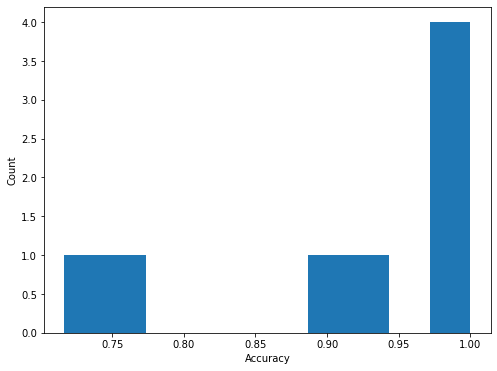

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(test_accs)
plt.xlabel("Accuracy")
plt.ylabel("Count")

The histogram shown above indicates the difficulty of training a good model on the reduced PPMI dataset due to the following factors,
- small amount of available data, i.e., only 20 graphs
- small amount of validation data since for a single fold only 2 graphs are used for validation
- the data are unbalanced since one class has twice as many nodes

Given the above, average performance as estimated using repeated k-fold cross validation displays high variance but overall good performance for a straightforward application of graph convolutional neural networks to supervised graph classification. The high variance is likely the result of the small dataset size.

Generally, performance is higher than SOTA in recent literature. However, we have not tuned the model to avoid overfittig possible so some improvement over the current baseline may be attainable.

When comparing to graph kernel-based approaches, our straightforward GCN with mean pooling graph classification model is competitive.

Text(0, 0.5, 'Count')

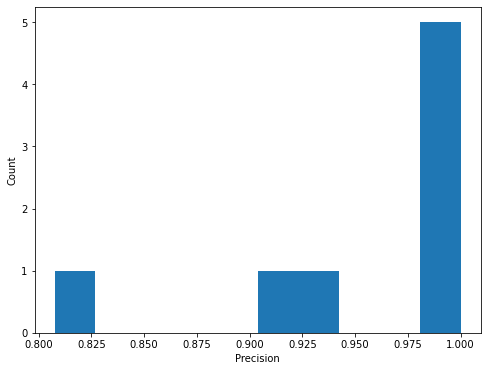

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(test_precision)
plt.xlabel("Precision")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

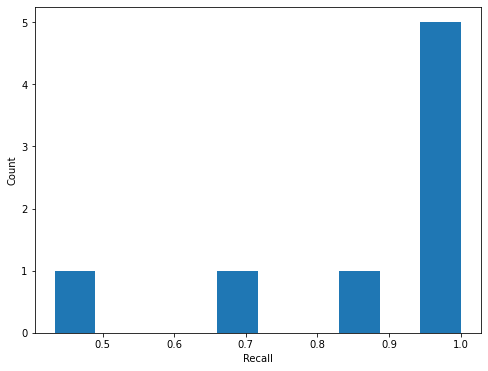

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(test_recall)
plt.xlabel("Recall")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

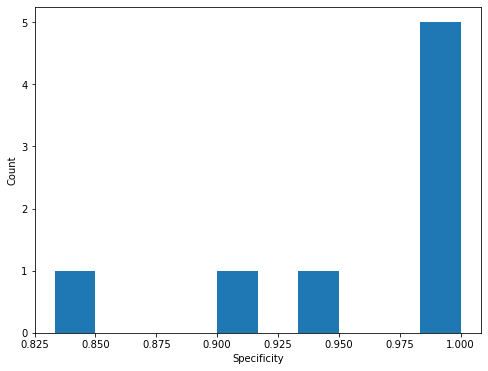

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(test_specificity)
plt.xlabel("Specificity")
plt.ylabel("Count")

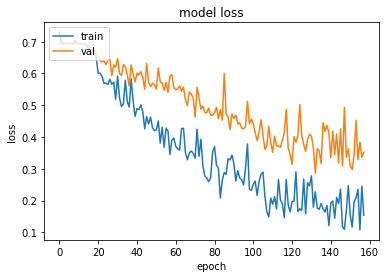

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/graph-classification/gcn-supervised-graph-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/graph-classification/gcn-supervised-graph-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

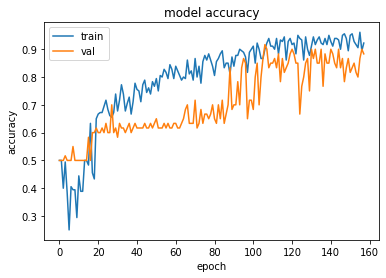

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# test_accs > 0.9
# test_precision > 0.9
# test_recall > 0.9
# test_specificity > 0.9

In [ ]:
print(test_specificity.tolist())

[1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9333333333333333]
